In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

Cloning into 'icpr2020dfdc'...
remote: Enumerating objects: 616, done.
remote: Counting objects: 100% (616/616), done.
remote: Compressing objects: 100% (535/535), done.
remote: Total 616 (delta 318), reused 322 (delta 49), pack-reused 0
Receiving objects: 100% (616/616), 68.57 MiB | 40.85 MiB/s, done.
Resolving deltas: 100% (318/318), done.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=22f19a352c26b1e63bf02dc88f832b377e92f8aa6d2eda5dbef3e14a46626ab4
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-khz09l2b
/content/icpr2020dfdc/notebook


In [105]:
!git clone https://github.com/jacobkimmel/pytorch_modelsize

Cloning into 'pytorch_modelsize'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 26 (delta 0), reused 1 (delta 0), pack-reused 22
Unpacking objects: 100% (26/26), done.


In [ ]:
import pandas as pd
import io
from google.colab import files
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.model_zoo import load_url
from scipy.special import expit

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace, VideoReader
from architectures import fornet,weights
from isplutils import utils

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
face_policy = 'scale'
face_size = 224
frames_per_video = 32

net_model = ['EfficientNetB4', 'EfficientNetB4ST', 'EfficientNetAutoAttB4', 'EfficientNetAutoAttB4ST', 'Xception']

train_db = ['DFDC', 'FFPP']

In [ ]:
model_url = []
net = []
for train_num in range(2):
  for model_num in range(5):
    model_url.append(weights.weight_url['{:s}_{:s}'.format(net_model[model_num],train_db[train_num])])
    net.append(getattr(fornet,net_model[model_num])().eval().to(device))
    net[model_num + (5 * train_num)].load_state_dict(load_url(model_url[model_num + (5 * train_num)],map_location=device,check_hash=True))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4_DFDC_bestval-c9f3663e2116d3356d056a0ce6453e0fc412a8df68ebd0902f07104d9129a09a.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4_DFDC_bestval-c9f3663e2116d3356d056a0ce6453e0fc412a8df68ebd0902f07104d9129a09a.pth


KeyboardInterrupt: ignored

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=50)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

transf = []
for x in range(10):
  transf.append(utils.get_transformer(face_policy, face_size, net[x].get_normalizer(), train=False))

NameError: ignored

In [ ]:
def test_10_models(filename, label):
  testimages = face_extractor.process_video(filename)
  testimages_real_face = []
  if (testimages != []):
    for x in range(10):
      testimages_real_face.append(torch.stack( [ transf[x](image=frame['faces'][0])['image'] for frame in testimages if len(frame['faces'])] ))

    result = [0,0,0,0,0,0,0,0,0,0]
    with torch.no_grad():
        result[0] = expit((net[0](testimages_real_face[0].to(device)).cpu().numpy().flatten())).mean()
        result[1] = expit((net[1](testimages_real_face[1].to(device)).cpu().numpy().flatten())).mean()
        result[2] = expit((net[2](testimages_real_face[2].to(device)).cpu().numpy().flatten())).mean()
        result[3] = expit((net[3](testimages_real_face[3].to(device)).cpu().numpy().flatten())).mean()
        result[4] = expit((net[4](testimages_real_face[4].to(device)).cpu().numpy().flatten())).mean()
        result[5] = expit((net[5](testimages_real_face[5].to(device)).cpu().numpy().flatten())).mean()
        result[6] = expit((net[6](testimages_real_face[6].to(device)).cpu().numpy().flatten())).mean()
        result[7] = expit((net[7](testimages_real_face[7].to(device)).cpu().numpy().flatten())).mean()
        result[8] = expit((net[8](testimages_real_face[8].to(device)).cpu().numpy().flatten())).mean()
        result[9] = expit((net[9](testimages_real_face[9].to(device)).cpu().numpy().flatten())).mean()

    correct = [0,0,0,0,0,0,0,0,0,0]
    line = 0.5

    if (label == "FAKE"):
      for y in range(10):
        if (result[y] > line):
          correct[y] = 1
    else:
      for y in range(10):
        if (result[y] < line):
          correct[y] = 1

    print(filename)
    print(correct)
    print(result)
  else:
    correct = [0,0,0,0,0,0,0,0,0,0]

  return correct

In [ ]:
best_model = test_10_models('aelfnikyqj.mp4', 0)

In [ ]:
def best_model_funct(fileList):
  model_tracker = np.array([0,0,0,0,0,0,0,0,0,0])
  for file in fileList.items():
    label = (file[1])['label']
    result = np.array(test_10_models(file[0], label))
    model_tracker = np.add(model_tracker, result)
  max = 0
  for x in range(10):
    if (model_tracker[x] > max):
      max = model_tracker[x]
      best = x

  if (best == 0 or best == 5):
    print('The best model is EfficientNetB4')
  elif (best == 1 or best == 6):
    print('The best model is EfficientNetB4ST')
  elif (best == 2 or best == 7):
    print('The best model is EfficientNetAutoAttB4')
  elif (best == 3 or best == 8):
    print('The best model is EfficientNetAutoAttB4ST')
  else:
    print('The best model is Xception')

  if (best < 5):
    print('with training set DFDC')
  else:
    print('with training set FFPP')

  return model_tracker

In [ ]:
uploaded = files.upload()
uploaded = files.upload()

In [ ]:
import json

In [ ]:
with open('metadata.json') as f:
  fileList = json.load(f)

results = best_model_funct(fileList)

aapnvogymq.mp4
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0.6016274, 0.5679076, 0.6019603, 0.5482208, 0.67734534, 0.33167046, 0.26646507, 0.1525922, 0.11882168, 0.3512975]
abarnvbtwb.mp4
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.056915592, 0.08413155, 0.04564752, 0.11296556, 0.053294893, 0.11388126, 0.09679797, 0.08208319, 0.12565416, 0.06696843]
abofeumbvv.mp4
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
[0.95978254, 0.84396863, 0.7717704, 0.90376127, 0.85673845, 0.6343939, 0.6556759, 0.46740046, 0.13703147, 0.6494561]
abqwwspghj.mp4
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0.9988044, 0.9606103, 0.99716383, 0.90436584, 0.99566233, 0.10874223, 0.09979164, 0.13633822, 0.10975524, 0.25573432]
acifjvzvpm.mp4
[1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
[0.8315741, 0.68609625, 0.6331646, 0.3919176, 0.942567, 0.14557548, 0.1979043, 0.14915308, 0.26045027, 0.15212947]
acqfdwsrhi.mp4
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0.99109083, 0.9714708, 0.982854, 0.9624226, 0.97526217, 0.5627043, 0.6003996, 0.7550926, 0.5442753, 0.36740062]
acxnxvbsxk.mp4
[1, 1, 

In [ ]:
print(results)

NameError: ignored

In [ ]:
uploaded = files.upload()

Saving aagfhgtpmv.mp4 to aagfhgtpmv.mp4
Saving aapnvogymq.mp4 to aapnvogymq.mp4
Saving abarnvbtwb.mp4 to abarnvbtwb.mp4
Saving abofeumbvv.mp4 to abofeumbvv.mp4
Saving abqwwspghj.mp4 to abqwwspghj.mp4
Saving acifjvzvpm.mp4 to acifjvzvpm.mp4
Saving acqfdwsrhi.mp4 to acqfdwsrhi.mp4
Saving acxnxvbsxk.mp4 to acxnxvbsxk.mp4
Saving acxwigylke.mp4 to acxwigylke.mp4
Saving aczrgyricp.mp4 to aczrgyricp.mp4


In [ ]:
data = [['aapnvogymq.mp4', 'abarnvbtwb.mp4', 'abofeumbvv.mp4', 'abqwwspghj.mp4', 'acifjvzvpm.mp4', 'acqfdwsrhi.mp4', 'acxnxvbsxk.mp4', 'acxwigylke.mp4', 'aczrgyricp.mp4'], [float(0),float(1),float(0),float(0),float(0),float(0),float(0),float(0),float(0)]]

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format('EfficientNetB4','FFPP')]
net = getattr(fornet,'EfficientNetB4')().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
videoreader = VideoReader(verbose=False)
video_read_fn = lambda x: videoreader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn=video_read_fn,facedet=facedet)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://f002.backblazeb2.com/file/icpr2020/EfficientNetB4_FFPP_bestval-93aaad84946829e793d1a67ed7e0309b535e2f2395acb4f8d16b92c0616ba8d7.pth" to /root/.cache/torch/hub/checkpoints/EfficientNetB4_FFPP_bestval-93aaad84946829e793d1a67ed7e0309b535e2f2395acb4f8d16b92c0616ba8d7.pth


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 5618)
        self.fc2 = nn.Linear(5618, 244)
        self.fc3 = nn.Linear(244, 1)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


lenet = Net()

In [28]:
batch_size = 4

videos = []
faces = []
for vid in ['aapnvogymq.mp4', 'abarnvbtwb.mp4', 'abofeumbvv.mp4', 'abqwwspghj.mp4', 'acifjvzvpm.mp4', 'acqfdwsrhi.mp4', 'acxnxvbsxk.mp4', 'acxwigylke.mp4', 'aczrgyricp.mp4']:
  images = face_extractor.process_video(vid)
  faces.append(torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in images if len(frame['faces'])] ))

labels = []
for aaa in range(9):
  for ccc in range(32):
    if aaa == 1:
      labels.append(1)
    else:
      labels.append(0)

data = [faces, labels]



trainset = data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [29]:
print(data)

[[tensor([[[[ 1.3070,  1.3070,  1.3070,  ..., -1.7754, -1.8097, -1.8439],
          [ 1.3070,  1.3070,  1.3070,  ..., -1.7240, -1.7583, -1.7925],
          [ 1.3070,  1.3070,  1.3070,  ..., -1.6042, -1.6727, -1.7069],
          ...,
          [ 1.0502,  1.0502,  1.0502,  ..., -0.2342, -0.2171, -0.1999],
          [ 1.0502,  1.0502,  1.0502,  ..., -0.2513, -0.2171, -0.1999],
          [ 1.0502,  1.0502,  1.0502,  ..., -0.2684, -0.2513, -0.2513]],

         [[ 1.5532,  1.5532,  1.5532,  ..., -1.7731, -1.8081, -1.8431],
          [ 1.5532,  1.5532,  1.5532,  ..., -1.7031, -1.7556, -1.7906],
          [ 1.5357,  1.5357,  1.5357,  ..., -1.5980, -1.6681, -1.7031],
          ...,
          [ 1.2031,  1.2031,  1.2031,  ..., -1.2829, -1.2654, -1.2479],
          [ 1.2031,  1.2031,  1.2031,  ..., -1.2829, -1.2654, -1.2479],
          [ 1.2031,  1.2031,  1.2031,  ..., -1.3179, -1.3004, -1.3004]],

         [[ 1.0191,  1.0191,  1.0191,  ..., -1.5953, -1.6302, -1.6650],
          [ 1.0191,  1.0191,

In [ ]:
import torch.optim as optim
import torch.tensor as Tensor

criterion = nn.BCELoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
        # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    inputa = torch.cat((inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], inputs[5], inputs[6], inputs[7], inputs[8]))
    inputa = inputa
    outputs = (lenet(inputa))

    print(outputs)
    labels = torch.FloatTensor(labels)

    outputs = outputs.flatten()

    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()

    # print statistics
    print(loss.item())
    epoch = epoch + 1

print('Finished Training')

tensor([[0.0751],
        [0.0795],
        [0.0784],
        [0.0783],
        [0.0791],
        [0.0805],
        [0.0794],
        [0.0942],
        [0.1021],
        [0.0966],
        [0.0984],
        [0.0943],
        [0.1014],
        [0.1034],
        [0.0987],
        [0.1033],
        [0.1063],
        [0.0952],
        [0.0847],
        [0.0810],
        [0.0634],
        [0.0633],
        [0.0714],
        [0.0780],
        [0.0868],
        [0.0898],
        [0.0970],
        [0.0751],
        [0.0784],
        [0.0757],
        [0.0819],
        [0.0767],
        [0.0788],
        [0.0795],
        [0.0826],
        [0.0734],
        [0.0703],
        [0.0767],
        [0.0647],
        [0.0663],
        [0.0661],
        [0.0714],
        [0.0757],
        [0.0685],
        [0.0753],
        [0.0536],
        [0.0757],
        [0.0688],
        [0.0778],
        [0.0823],
        [0.0792],
        [0.0791],
        [0.0772],
        [0.0746],
        [0.0695],
        [0

In [ ]:
torch.save(lenet, './lenet.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [108]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

class SizeEstimator(object):

    def __init__(self, model, input_size=(1,1,32,32), bits=32):
        '''
        Estimates the size of PyTorch models in memory
        for a given input size
        '''
        self.model = model
        self.input_size = input_size
        self.bits = bits
        return

    def get_parameter_sizes(self):
        '''Get sizes of all parameters in `model`'''
        mods = list(self.model.modules())
        sizes = []
        
        for i in range(1,len(mods)):
            m = mods[i]
            p = list(m.parameters())
            for j in range(len(p)):
                sizes.append(np.array(p[j].size()))

        self.param_sizes = sizes
        return

    def get_output_sizes(self):
        '''Run sample input through each layer to get output sizes'''
        input_ = Variable(torch.FloatTensor(*self.input_size), volatile=True)
        mods = list(self.model.modules())
        out_sizes = []
        for i in range(1, len(mods)):
            m = mods[i]
            out = m(input_)
            out_sizes.append(np.array(out.size()))
            input_ = out

        self.out_sizes = out_sizes
        return

    def calc_param_bits(self):
        '''Calculate total number of bits to store `model` parameters'''
        total_bits = 0
        for i in range(len(self.param_sizes)):
            s = self.param_sizes[i]
            bits = np.prod(np.array(s))*self.bits
            total_bits += bits
        self.param_bits = total_bits
        return

    def calc_forward_backward_bits(self):
        '''Calculate bits to store forward and backward pass'''
        total_bits = 0
        for i in range(len(self.out_sizes)):
            s = self.out_sizes[i]
            bits = np.prod(np.array(s))*self.bits
            total_bits += bits
        # multiply by 2 for both forward AND backward
        self.forward_backward_bits = (total_bits*2)
        return

    def calc_input_bits(self):
        '''Calculate bits to store input'''
        self.input_bits = np.prod(np.array(self.input_size))*self.bits
        return

    def estimate_size(self):
        '''Estimate model size in memory in megabytes and bits'''
        self.get_parameter_sizes()
        self.get_output_sizes()
        self.calc_param_bits()
        self.calc_forward_backward_bits()
        self.calc_input_bits()
        total = self.param_bits + self.forward_backward_bits + self.input_bits

        total_megabytes = (total/8)/(1024**2)
        return total_megabytes, total

In [125]:
se = SizeEstimator(lenet, input_size=(106, 3, 224, 224))
estimate = se.estimate_size()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


RuntimeError: ignored

In [67]:
filelist = files.upload()

Saving aagfhgtpmv.mp4 to aagfhgtpmv (2).mp4
Saving aapnvogymq.mp4 to aapnvogymq (2).mp4
Saving abarnvbtwb.mp4 to abarnvbtwb (2).mp4
Saving abofeumbvv.mp4 to abofeumbvv (1).mp4
Saving abqwwspghj.mp4 to abqwwspghj (1).mp4
Saving acifjvzvpm.mp4 to acifjvzvpm (1).mp4
Saving acqfdwsrhi.mp4 to acqfdwsrhi (1).mp4
Saving acxnxvbsxk.mp4 to acxnxvbsxk (1).mp4
Saving acxwigylke.mp4 to acxwigylke (1).mp4
Saving aczrgyricp.mp4 to aczrgyricp (1).mp4
Saving adhsbajydo.mp4 to adhsbajydo (1).mp4
Saving adohikbdaz.mp4 to adohikbdaz (1).mp4
Saving adylbeequz.mp4 to adylbeequz (3).mp4
Saving aelfnikyqj.mp4 to aelfnikyqj (2).mp4
Saving aelzhcnwgf.mp4 to aelzhcnwgf.mp4
Saving aettqgevhz.mp4 to aettqgevhz.mp4
Saving aevrfsexku.mp4 to aevrfsexku.mp4
Saving afoovlsmtx.mp4 to afoovlsmtx (1).mp4
Saving agdkmztvby.mp4 to agdkmztvby.mp4
Saving agqphdxmwt.mp4 to agqphdxmwt.mp4
Saving agrmhtjdlk.mp4 to agrmhtjdlk.mp4
Saving ahbweevwpv.mp4 to ahbweevwpv.mp4
Saving ahdbuwqxit.mp4 to ahdbuwqxit.mp4
Saving ahfazfbntc.mp

In [130]:
def data_and_label(videos, videolabels):
  batch_size = 4

  newvideos = []
  newfaces = []
  labels = []
  for i in tqdm(range(1)):
    images = face_extractor.process_video(videos[i])
    if not images == []:
      newfaces.append(torch.stack( [ transf(image=frame['faces'][0])['image'] for frame in images if len(frame['faces'])] ))
      labels.append(videolabels[i])
    else:
      print(vid)

  return [newfaces, labels]

In [85]:
def get_net_out(newdata):
  inputs, labels = newdata
  print(inputs)
  inputs = torch.cat(tuple(inputs))
  outputs = lenet(inputs)
  return outputs

In [128]:
def get_predictions(outputs):
  o = outputs.flatten()
  size = o.shape[0]
  out = []
  for i in tqdm(range(0, 0, 32)):
    out.append(torch.mean(torch.narrow(o, 0, i, 32)))
  return out

In [72]:
up = files.upload()
import json
videonames = []
videolabels = []
with open('metadata.json') as f:
  fileList = json.load(f)
  for file in fileList.items():
    label = (file[1])['label']
    videonames.append(file[0])
    videolabels.append(0 if file[1]['label'] == 'FAKE' else 1)

Saving metadata.json to metadata (2).json


In [ ]:
out = data_and_label(videonames, videolabels)




  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
out.shape

In [ ]:
out = get_net_out(out)

In [126]:
out.shape

torch.Size([1024, 1])

In [87]:
predictions = get_predictions(out)

In [89]:
predictions

[tensor(0.0525, grad_fn=<MeanBackward0>),
 tensor(0.0859, grad_fn=<MeanBackward0>),
 tensor(0.0723, grad_fn=<MeanBackward0>),
 tensor(0.1075, grad_fn=<MeanBackward0>),
 tensor(0.0655, grad_fn=<MeanBackward0>),
 tensor(0.0870, grad_fn=<MeanBackward0>),
 tensor(0.0918, grad_fn=<MeanBackward0>),
 tensor(0.0604, grad_fn=<MeanBackward0>),
 tensor(0.0616, grad_fn=<MeanBackward0>),
 tensor(0.0671, grad_fn=<MeanBackward0>),
 tensor(0.1067, grad_fn=<MeanBackward0>),
 tensor(0.0673, grad_fn=<MeanBackward0>),
 tensor(0.0657, grad_fn=<MeanBackward0>),
 tensor(0.0716, grad_fn=<MeanBackward0>),
 tensor(0.0671, grad_fn=<MeanBackward0>),
 tensor(0.0730, grad_fn=<MeanBackward0>),
 tensor(0.0882, grad_fn=<MeanBackward0>),
 tensor(0.0915, grad_fn=<MeanBackward0>),
 tensor(0.0866, grad_fn=<MeanBackward0>),
 tensor(0.0580, grad_fn=<MeanBackward0>),
 tensor(0.0769, grad_fn=<MeanBackward0>),
 tensor(0.0679, grad_fn=<MeanBackward0>),
 tensor(0.0749, grad_fn=<MeanBackward0>),
 tensor(0.0873, grad_fn=<MeanBackw

In [93]:
pred_vals = [predictions[i].item() for i in range(len(predictions))]

In [99]:
from matplotlib import pyplot as plt
len(pred_vals)
len(videonames)

400

<BarContainer object of 32 artists>

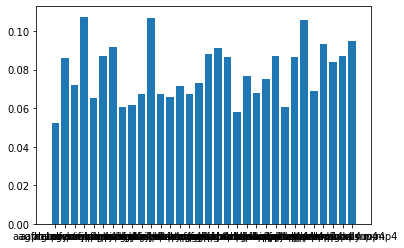

In [100]:
plt.bar(videonames[:32], pred_vals)

<BarContainer object of 6 artists>

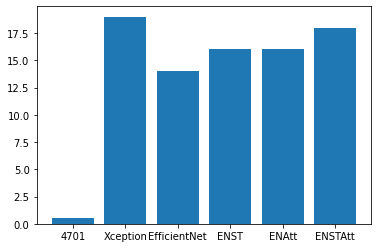

In [101]:
plt.bar(['4701', 'Xception', 'EfficientNet', 'ENST', 'ENAtt', 'ENSTAtt'], [0.5, 19, 14, 16, 16, 18])